In [1]:
import setGPU

setGPU: Setting GPU to: 0


In [2]:
from typing import Any, Generator, Tuple, Mapping, Sequence, Optional, Callable, Union, NamedTuple
from collections import namedtuple
import functools, inspect, time, random

import pandas as pd
import numpy as np
from absl import app
import haiku as hk
import jax
from jax.experimental import optix
from jax.tree_util import tree_multimap, tree_map, tree_reduce, tree_leaves
import jax.numpy as jnp
from jax.lax import fori_loop
import tensorflow_datasets as tfds
import tensorflow_federated as tff
import tensorflow as tf

In [3]:
Batch = Mapping[str, jnp.ndarray]
DatasetSequence = Sequence[tf.data.Dataset]
LossFunction = Callable[[hk.Params, Batch], jnp.ndarray]
OptState = Any
ClientState = namedtuple("ClientState", "next_idx\
                                         epoch_count\
                                         similarity")


# define hyperparameters format.
ServerHyperParams = namedtuple("ServerHyperParams", "num_rounds\
                                                     max_batches_per_round\
                                                     max_epochs_per_round\
                                                     batch_size\
                                                     seed")

# Define the aggregator format
SimilarityAggregatorHyperParams = namedtuple("SimilarityAggregatorHyperParams", "distance_penalty_factor")
AverageAggregatorHyperParams = namedtuple("AverageAggregatorHyperParams", "")
AggregatorHyperParams = Union[SimilarityAggregatorHyperParams, AverageAggregatorHyperParams]
AggregatorFunction = Callable[[Sequence[hk.Params], Sequence[ClientState], AggregatorHyperParams], Tuple[hk.Params, Sequence[ClientState]]]
class Aggregator(NamedTuple):
    aggregator_function: AggregatorFunction
    aggregator_hyperparams: AggregatorHyperParams

# message to the client from server.
ClientMessage = namedtuple("ClientMessage", "params\
                                             opt_init_input")

# message to the server from client.
ServerMessage = namedtuple("ServerMessage", "aggregator_input\
                                             stateupdater_input")


# message to the server from client for book keeping.
DiagnosticsMessage = namedtuple("DiagnosticsMessage", "train_loss\
                                                       train_acc\
                                                       test_loss\
                                                       test_acc\
                                                       weight")
ClientOutput = Tuple[ServerMessage, DiagnosticsMessage]

# extracts messages from a list of client outputs.
@jax.partial(jax.jit, static_argnums=[1])  # fix extractor.
def extract_from_cout(
    couts: Sequence[ClientOutput],
    extractor: Callable[[ClientOutput], Any]
    ) -> Sequence[Any]:
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  # TODO: use pytrees.transpose?
  # msgs = fori_loop(0, len(couts),
  #                    lambda i, msgs: msgs.append(extractor(couts[i])), [])
  msgs = [extractor(cout) for cout in couts]
  return msgs

def init_client_states(client_data: Sequence[tf.data.Dataset]) -> Sequence[ClientState]:
  return [ClientState(next_idx=0,
                      epoch_count=0,
                      similarity=1) for i in range(len(client_data))]

def make_jax_batch(batch: Mapping[str, tf.Tensor]) -> Batch:
    """Transform a Mapping[str, tf.Tensor] (tensorflow batch)
    into a Mapping[str, jnp.array] (jax-compatible batch)."""
    jax_batch = {}
    for key in batch:
        jax_batch[key] = jnp.array(batch[key].numpy())
    return jax_batch

In [4]:
# JaxDataset = Sequence[Batch]
# def make_jax_dataset(ds: tf.data.Dataset)

In [5]:
def load_2017annie_predict_EVD():
    X = np.loadtxt('../data/private/predict_EVD/X.csv', skiprows=1, delimiter=',')
    y = np.loadtxt('../data/private/predict_EVD/y.csv', skiprows=1, delimiter=',')
    assert (X.shape[0] == y.shape[0])
    return X,y

# This function is not stateless, due to the use of random.shuffle. It is used only once, before the training loop.
def split_by_age(
        X: np.ndarray,
        y: np.ndarray,
        hyperparams: ServerHyperParams,
        requesting_client: int = 0,
        test_ratio: float = 0.5
) -> Tuple[DatasetSequence, tf.data.Dataset]:
    """ Split the datum points (X,y) into three datasets based on the age of the patients.
    The patients are sorted into age groups [1-20y, 21-40y, >40y].
    The batches within each set are shuffled.
    
    requesting_client: Index of the age group for which a test set is created.
    The training set for the requesting client is placed at index 0 in the returned
    DatasetSequence.
    """
    
    def make_ds(idx):
        return tf.data.Dataset.from_tensor_slices({'features': X[idx], 'label':y[idx]})\
            .batch(hyperparams.batch_size)
    
    ages = pd.read_csv('../data/private/0_raw_EbolaDatabase.csv')['age'].to_numpy()
    age_lims = [-1, 20, 40, 1e3]
    dss, ds_test = [0], None
    
    for i, (lower, upper) in enumerate(zip(age_lims[:-1], age_lims[1:])):
        idx = np.asarray((lower < ages) & (ages <= upper)).nonzero()[0]
        random.shuffle(idx)
        if i == requesting_client:
            test_size = hyperparams.batch_size * (1 + int(len(idx) // hyperparams.batch_size * test_ratio))
            ds_test = make_ds(idx[:test_size])
            dss[0] = make_ds(idx[test_size:])
        else:
            dss.append( make_ds(idx) )
    
    if ds_test is None:
        raise ValueError("Unexpected 'requesting_client' argument: Expecting a non-negative int lower or equal to {}.".format(len(age_lims)-2))
    
    return dss, ds_test

In [6]:
# X, y = load_2017annie_predict_EVD()
# X_id = np.hstack((np.arange(X.shape[0]).reshape((X.shape[0], 1)), X))
# X_id

In [7]:
# hyperparams = ServerHyperParams(
#     num_rounds = 30,
#     max_batches_per_round = 3,
#     max_epochs_per_round = 1,
#     batch_size = 10,
#     seed = 420
# )
# dss, ds_test = split_by_age(X, y, hyperparams)    

In [8]:
# Neural network model.
def net_fn(batch: Batch) -> jnp.ndarray:
  """Logistic regression for 2-class classification."""
  x = batch["features"]
  logistic_reg = hk.Sequential([
      hk.Flatten(),
      hk.Linear(2), jax.nn.log_softmax
  ])
  return logistic_reg(x)
net: hk.Transformed = hk.transform(net_fn)

# Initialize neural network parameters 
def init(rng: jax.random.PRNGKey, batch: Batch) -> hk.Params:
  return net.init(rng, batch)

# get predictions from model.
def forward(params: hk.Params, batch: Batch):
  return jax.jit(net.apply)(params, batch)


# Training loss (cross-entropy).
@jax.jit
def loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """Compute the loss of the network, including L2."""
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  preds = forward(params, batch)
  labels = hk.one_hot(batch["label"], 2)
  # TODO: Put weight decay into optimizer
  l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
  softmax_xent = -jnp.mean(labels * preds)
  return softmax_xent + 1e-4 * l2_loss

# Evaluation metric (classification accuracy).
@jax.jit
def accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  preds = forward(params, batch)
  pred_class = jnp.argmax(preds, axis=-1)
  return jnp.mean(pred_class == batch["label"])

In [9]:
# one local update step.
@jax.partial(jax.jit, static_argnums=[2,4])  # fix loss function and optimizer.
def run_one_step(
    params: hk.Params,
    batch: Batch,
    client_opt: optix.InitUpdate,
    opt_state: OptState,
    loss: LossFunction
    ) -> Tuple[hk.Params, OptState]:
  """Learning rule (stochastic gradient descent)."""
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  grads = jax.grad(loss)(params, batch)
  updates, opt_state = client_opt.update(grads, opt_state)
  new_params = optix.apply_updates(params, updates)
  return new_params, opt_state  

# perform client updates.
def client_updater(
    msg: ClientMessage,
    ds: Sequence[Batch],
    client_opt: optix.InitUpdate,
    loss: LossFunction
    ) -> ClientOutput:
  opt_state = client_opt.init(*msg.opt_init_input)
  # iterate through data making updates.
  new_params = msg.params
  for minibatch in ds:
    new_params, opt_state = run_one_step(new_params,
                                         minibatch,
                                         client_opt, 
                                         opt_state, 
                                         loss)
  # compute and return the change in parameters.
  params_update = tree_multimap(lambda x, y: x - y, new_params, msg.params)
  
  # TODO: replace with an function which constructs message  
  msg_to_server = ServerMessage(
      aggregator_input=params_update,
      stateupdater_input=None
  )

  diagnostic_msg = DiagnosticsMessage(
      train_loss=0,
      train_acc=1,
      test_loss=0,
      test_acc=1,
      weight=1
  )
  return msg_to_server, diagnostic_msg

In [10]:
# Absolutely not suitable for jit-compilation.
def make_client_data(
    ds: tf.data.Dataset,
    client_state: ClientState,
    hyperparams: ServerHyperParams
) -> Tuple[Sequence[Batch], ClientState]:
  batches_before, batches_after = [], []
  
  # Initially skip all the way to client_state.next_idx:
  for i, batch in enumerate(ds):
    if i < client_state.next_idx:
      batches_before.append(
        make_jax_batch(batch)
      )
    # Return once num_batches batches have been selected:
    elif len(batches_after) >= hyperparams.max_batches_per_round:
      client_state = client_state._replace(next_idx = i)
      return batches_after, client_state
    # Transform the tf batch to a Batch (Mapping[str, jnp.array])
    else:
      batches_after.append(
        make_jax_batch(batch)
      )
  
  # Traverse the dataset up to max_epochs-1 more times, until num_batches
  # batches are in batches_after
  for epoch in range(hyperparams.max_epochs_per_round - 1):
    # Increment the client's epoch_count
    client_state = client_state._replace(
                            next_idx = 0,
                            epoch_count = client_state.epoch_count + 1
                            )
    
    for i, batch in enumerate(ds):
      # Return once num_batches batches have been selected:
      if len(batches_after) >= hyperparams.max_batches_per_round:
        client_state = client_state._replace(next_idx = i)
        return batches_after, client_state
      # Transform the tf batch to a Batch (Mapping[str, jnp.array])
      batches_after.append(
        make_jax_batch(batch)
      )
  
  # If num_batches has not yet been reached,
  # add (some or all of) the batches_before at the end:
  num_to_add = hyperparams.max_batches_per_round - len(batches_after)
  batches_to_add = batches_before[:num_to_add]
  client_state = client_state._replace(next_idx = len(batches_to_add))
  batches_after += batches_to_add
  return batches_after, client_state

def make_all_client_data(
    client_data: Sequence[tf.data.Dataset],
    client_states: Sequence[ClientState],
    hyperparams: ServerHyperParams
) -> Tuple[Sequence[Sequence[Batch]], Sequence[ClientState]]:
  if not (len(client_states) == len(client_data)):
    raise ValueError(
        "Number of datasets ({}) does not fit number of client "
        "states ({})!".format(len(client_data), len(client_states))
        )
  dss_jax, client_states_after = [], []
  for ds, client_state_before in zip(client_data, client_states):
    batches_jax, client_state_after = make_client_data(ds, client_state_before, hyperparams)
    dss_jax.append(batches_jax)
    client_states_after.append(client_state_after)
  return dss_jax, client_states_after

In [11]:
# aggregate client updates.
# TODO: make the aggregator stateful.
@jax.jit
def average_params(params_list: Sequence[hk.Params],
                   client_states: Sequence[ClientState],
                   hyperparams: AverageAggregatorHyperParams
                  ) -> hk.Params: 
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  num_params = len(params_list)
  params_sum = functools.reduce(
      lambda t1, t2: tree_multimap(sum, t1, t2), params_list)
  params_avg = tree_map(lambda x: x/num_params, params_sum)
  return params_avg, client_states

@jax.jit
def normalize_array_l2(x: jnp.array) -> jnp.array:
    return x / jnp.sqrt(jnp.dot(x, x))

@jax.jit
def normalize_array_l1(x: jnp.array) -> jnp.array:
    return x / jnp.sum(jnp.abs(x))

@jax.jit
def tree_norm(tree: hk.Params) -> jnp.array:
    return jnp.sqrt(
               jnp.sum(
                   tree_leaves(
                       tree_map(
                           lambda x: jnp.sum(x*x),
                           tree
                       )
                   )
               )
           )

@jax.jit
def calc_rel_distances_of_others(reference_update: hk.Params,
                                 other_updates: Sequence[hk.Params]
                                ) -> Sequence[Any]:
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  # Compare the distances to the norm of the reference update.
  reference_norm = tree_norm(reference_update)
  return [ tree_norm(tree_multimap(lambda x, y: x-y, update, reference_update))
           / reference_norm 
           for update in other_updates ]

@jax.partial
def sum_args(*args):
  print("compiling: {} with {} arguments".format(inspect.currentframe().f_code.co_name, len(args)))
  return sum(args)

@jax.jit
def similarity_aggregator(updates_list: Sequence[hk.Params],
                          client_states: Sequence[ClientState],
                          hyperparams: SimilarityAggregatorHyperParams
                         ) -> hk.Params:
    print("compiling: {}".format(inspect.currentframe().f_code.co_name))
    assert len(updates_list) == len(client_states)
    reference_update = updates_list[0]
    other_updates = updates_list[1:]
    rel_distances_of_others = calc_rel_distances_of_others(reference_update,
                                                           other_updates)
    print("rel_distances_of_others:", rel_distances_of_others)
    
    # Each dataset starts with a similarity of 1, which can only decrease over time.
    # At every round, each dataset's similarity could decrease by something like:
    # some_factor * (1+client_state.epoch_count) * rel_distance
    for client_id, rel_distance in enumerate(rel_distances_of_others, start=1):
        c = client_states[client_id]
        print(c.similarity)
        similarity = (
            c.similarity
            - hyperparams.distance_penalty_factor * (1+c.epoch_count) * rel_distance
            ).astype(float)
        client_states[client_id] = c._replace(similarity=similarity)
    
    print([c.similarity for c in client_states])
    weights = normalize_array_l1(jnp.array([c.similarity for c in client_states]))
    weighted_updates = [tree_map(lambda x: w*x, update) for w, update in zip(weights, updates_list)]
    aggregated_update = tree_multimap(sum_args, *weighted_updates)
    return aggregated_update, client_states

def init_average_aggregator():
    return Aggregator(aggregator_function    = average_params,
                      aggregator_hyperparams = AverageAggregatorHyperParams()
                     )

def init_similarity_aggregator(distance_penalty_factor: float = 0.05) -> Aggregator:
    similarity_hyperparams = SimilarityAggregatorHyperParams(
            distance_penalty_factor=distance_penalty_factor
    )
    return Aggregator(aggregator_function    = similarity_aggregator,
                      aggregator_hyperparams = similarity_hyperparams
                     )

running round 0
computing updates from active clients.
compiling: run_one_step
aggregating client updates.
compiling: server_updater
compiling: extract_from_cout
compiling: similarity_aggregator
compilinserver_paramsalc_rel_distances_of_others
frozendict({
  'linear': frozendict({
              'b': Traced<ShapedArray(float32[2]):JaxprTrace(level=-1/3)>,
              'w': Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/3)>,
            }),
})
Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/3)>
<class 'jax.interpreters.partial_eval.JaxprTracer'> : Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/3)>
rel_distances_of_others: [Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/2)>, Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/2)>]
Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/2)>
Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/2)>
[Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/2)>, Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/2)>, Traced<ShapedArray(float32[9,2]):JaxprTrace(level=-1/2)>]

In [12]:
# aggregate diagnositcs.
@jax.jit
def agg_diagnostics(
    client_outputs: Sequence[ClientOutput]) -> DiagnosticsMessage:
  d_msgs = extract_from_cout(client_outputs, lambda cout: cout[1])
  # TODO: aggregate and report statistics
  return d_msgs[0]


# update server params.
@jax.partial(jax.jit, static_argnums=[3,5])  # fix optimizer and aggregator.
def server_updater(
    server_params: hk.Params,
    client_outputs: Sequence[ClientOutput],
    client_states: Sequence[ClientState],
    server_opt: optix.InitUpdate,
    opt_state: OptState,
    aggregator: Aggregator
) -> Tuple[hk.Params, Sequence[ClientState], OptState]:
  print("compiling: {}".format(inspect.currentframe().f_code.co_name))
  agg_inputs = extract_from_cout(client_outputs,
                                 lambda cout: cout[0].aggregator_input)
  agg_update, client_states_out = aggregator.aggregator_function(
                                                agg_inputs,
                                                client_states,
                                                aggregator.aggregator_hyperparams
                                                )
  eff_grads = tree_map(lambda x: -1.0*x, agg_update)  # effective gradient.
  updates, opt_state = server_opt.update(eff_grads, opt_state)
  # TODO: allow opt_state to also be explicitly updated by state_updater
  server_params = optix.apply_updates(server_params, updates)
  return server_params, client_states_out, opt_state

# one round of federated learning.
def run_one_round(
    server_params: hk.Params,
    hyperparams: ServerHyperParams,
    client_data: Sequence[tf.data.Dataset],
    client_states: Sequence[ClientState],
    client_opt: optix.InitUpdate,
    server_opt: optix.InitUpdate,
    opt_state: OptState,
    aggregator: Aggregator,
    loss: LossFunction,
    rng: jax.random.PRNGKey
) -> Tuple[hk.Params, Sequence[ClientState], OptState]:
  
  print("computing updates from active clients.")
  # TODO: replace with an function which constructs message
  msg_to_clients = ClientMessage(
      params=server_params, 
      opt_init_input=[server_params])
  
  dss, client_states_upd = make_all_client_data(client_data, client_states, hyperparams)
  
  client_outputs = list(map(lambda ds: client_updater(
                          msg_to_clients,
                          ds,
                          client_opt,
                          loss), dss))
  
  print("aggregating client updates.")
  server_params, client_states_out, opt_state = server_updater(
      server_params,
      client_outputs,
      client_states_upd,
      server_opt,      
      opt_state,      
      aggregator)
  
  # TODO: aggregate and incporate new diagnostics. needs state!
  diag_state = agg_diagnostics(client_outputs)
  
  return server_params, client_states_out, opt_state

In [13]:
# # Testing one round of federated averaging.
# batch_size=10
# dss, ds_test = split_by_age(*load_2017annie_predict_EVD(), batch_size)
# client_states = init_client_states(dss)

In [14]:
# params = init(jax.random.PRNGKey(42), dss[0].as_numpy_iterator().next())

In [15]:
# client_opt = optix.sgd(0.1)
# server_opt = optix.sgd(1.0)
# opt_state = server_opt.init(params)
# rng = jax.random.PRNGKey(0)
# hyperparams = ServerHyperParams(
#     num_rounds = 12,
#     max_batches_per_round = 5000,
#     max_epochs_per_round = 1,
#     batch_size = 10,
#     seed = 7
# )

# run_one_round(
#     params,
#     hyperparams,
#     dss,
#     client_states,
#     client_opt,
#     server_opt,
#     opt_state,
#     average_params,
#     loss,
#     rng
# );

In [16]:
def eval_test_score(params: hk.Params, ds: tf.data.Dataset) -> jnp.ndarray:
    accs = []
    for batch in ds:
        accs.append(accuracy(params, make_jax_batch(batch)))
    return np.mean(accs)

In [17]:
def federated_learning(
    client_data: Sequence[tf.data.Dataset],
    aggregator: Aggregator,
    hyperparams: ServerHyperParams,
    client_opt: optix.InitUpdate,
    server_opt: optix.InitUpdate,
    loss: LossFunction,
    init
    ) -> hk.Params:
  # initialize random generator, params, opt_state.
  rng = jax.random.PRNGKey(hyperparams.seed)
  # TODO: use synthethic data for init
  server_params = init(rng, client_data[0].as_numpy_iterator().next())
  client_states = init_client_states(client_data)
  opt_state = server_opt.init(server_params)
  rngs = jax.random.split(rng, hyperparams.num_rounds)
  
#   train_
  for round_num, rng in enumerate(rngs):
    print("\nrunning round {}".format(round_num))
    server_params, \
    client_states, \
    opt_state       = run_one_round(server_params, hyperparams, 
                                    client_data, client_states, client_opt, 
                                    server_opt, opt_state, 
                                    aggregator, loss, rng)
  return server_params

In [21]:
# testing federated learning code.

hyperparams = ServerHyperParams(
    num_rounds = 30,
    max_batches_per_round = 3,
    max_epochs_per_round = 1,
    batch_size = 10,
    seed = 420
)

sim_aggregator = init_similarity_aggregator()
avg_aggregator = init_average_aggregator()

constant_inputs = (
        hyperparams,
        optix.sgd(0.1),
        optix.sgd(1.0),
        loss,
        init
)

random.seed(hyperparams.seed)

test_scores = {}
for requesting_client in range(3):
    dss, ds_test = split_by_age(*load_2017annie_predict_EVD(), hyperparams, requesting_client)
    
    training_types = {
        'global' : (dss,      avg_aggregator),
        'similar': (dss,      sim_aggregator),
        'local'  : (dss[0:1], avg_aggregator),
    }

    for key, varied_inputs in training_types.items():
        opt_params_global = federated_learning(
            *varied_inputs,
            *constant_inputs
            );
        if not key in test_scores:
            test_scores[key] = []
        test_scores[key].append( eval_test_score(opt_params_global, ds_test) )

/home/grimberg/.local/share/virtualenvs/semester-project-privateML-TGzbS9iS/lib/python3.7/site-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))



running round 0
computing updates from active clients.
compiling: run_one_step
aggregating client updates.
compiling: server_updater
compiling: extract_from_cout

running round 1
computing updates from active clients.
aggregating client updates.
compiling: server_updater
compiling: extract_from_cout

running round 2
computing updates from active clients.
aggregating client updates.

running round 3
computing updates from active clients.
aggregating client updates.

running round 4
computing updates from active clients.
aggregating client updates.

running round 5
computing updates from active clients.
aggregating client updates.

running round 6
computing updates from active clients.
aggregating client updates.

running round 7
computing updates from active clients.
aggregating client updates.

running round 8
computing updates from active clients.
compiling: run_one_step
aggregating client updates.

running round 9
computing updates from active clients.
aggregating client updates.

r

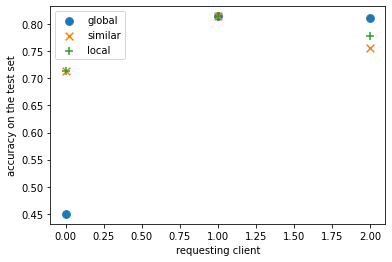

In [38]:
import matplotlib.pyplot as plt
markers = {k:v for k,v in zip(test_scores.keys(), 'ox+svp'*8)}
for key, val in test_scores.items():
    x = np.arange(len(val))
    plt.scatter(x, val, label=key, marker=markers[key], s=60)
plt.legend()
plt.xlabel('requesting client')
plt.ylabel('accuracy on the test set')
plt.show()

In [ ]:
test_scores

# Questions

1. Does the net.init also initialize the output layer based on batch size?